In [1]:
import numpy as np
import pandas as pd

from proglearn.forest import LifelongClassificationForest as l2f
from proglearn.transformers import TreeClassificationTransformer as transformer
from proglearn.voters import TreeClassificationVoter as voter

from tasksim import task_similarity, generate_hierarchy
from proglearn import LifelongClassificationForest as l2f

from graspy.embed import AdjacencySpectralEmbed as ASE
from graspy.cluster import AutoGMMCluster as GMM

import torchvision

from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from joblib import Parallel, delayed
import pickle
import time
from tqdm import tqdm
import os

In [2]:
class Dataset:
    def __init__(self, file, train=True, classes=[]):
        if train:
            self.data = pickle.load(open('cifar_resnet50_embed.p', 'rb'))[0]
            self.targets = np.concatenate(pickle.load(open('cifar_resnet50_embed.p', 'rb'))[1])
        else:
            self.data = pickle.load(open('cifar_resnet50_embed.p', 'rb'))[2]
            self.targets = np.concatenate(pickle.load(open('cifar_resnet50_embed.p', 'rb'))[3])
        
        self.classes = classes

In [3]:
cif100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
trainset = Dataset('cifar_resnet50_embed.p', classes=cif100.classes)
testset = Dataset('cifar_resnet50_embed.p', train=False, classes=cif100.classes)

Files already downloaded and verified


In [4]:
data_dimension=1000

if data_dimension < trainset.data.shape[1]:
    pca = PCA(n_components=data_dimension)
    pca.fit(trainset.data)
    trainset.data = pca.transform(trainset.data)
    testset.data = pca.transform(testset.data)

In [72]:
# def generate_dist_matrix(data, dissimilarity = 'task-sim', acorn=None):        
#     n_dists = len(data)    
#     labels = [i*np.ones(data[i].shape[0]) for i in range(n_dists)]
        
#     distances = np.zeros((n_dists, n_dists))
    
#     if dissimilarity == 'eucl-means':
#         means = np.mean(data, axis=1)
#         return pairwise_distances(means)
        
#     for i in range(n_dists):
#         for j in range(n_dists):
#             if i == j:
#                 continue
                
#             if dissimilarity == 'task-sim':
#                 for k in range(n_dists):
#                     if k == i or k == j:
#                         continue
                                                
#                     temp_task1 = (np.concatenate([data[i], data[k]], axis=0), np.concatenate([labels[i], labels[k]]))
#                     temp_task2 = (np.concatenate([data[j], data[k]], axis=0), np.concatenate([labels[j], labels[k]]))


#                     distances[i,j] += task_similarity(temp_task1, temp_task2)
#                 distances[i] /= n_dists-2
                
#             else:
#                 raise ValueError('other distances not implemented')
        
#     return distances

# def preprocess_dist_matrix(dist_matrix, make_symmetric=True, scale=True, aug_diag=True):
#     if make_symmetric:
#         dist_matrix = 0.5*(dist_matrix + dist_matrix.T)
        
#     if aug_diag:
#         dist_matrix = dist_matrix + np.diag(np.mean(dist_matrix, axis=0))
        
#     if scale:
#         dist_matrix = (dist_matrix - np.min(dist_matrix)) / (np.max(dist_matrix) - np.min(dist_matrix))
        
#     return dist_matrix

# def cluster_dists(dist_matrix, embedding=ASE, cluster=GMM):
#     if embedding is not None:
#         X_hat = embedding().fit_transform(dist_matrix)
#     else:
#         X_hat = dist_matrix
         
#     return cluster().fit_predict(X_hat)

def evaluate_clusters(f, truth, preds, calculate_random=False, n_mc=500, acorn=None):
    eval_pred = f(truth, preds)
    
    if not calculate_random:
        return eval_pred
    
    eval_random = np.zeros(n_mc)
    for i in range(n_mc):
        np.random.shuffle(preds)
        eval_random[i] = f(truth, preds)
        
    return eval_pred, np.mean(eval_random)

def evaluate_accuracy(data, labels, truth, preds, n_trees_coarse=25, n_trees_fine=10, train_flat=True,
                     test_data=None, test_labels=None, max_depth=5,
                     acorn=None):
    classes = np.unique(labels)
    
    forests_dict = {
            'coarse_truth': None, 
            'fine_truth': {c: None for c in np.unique(truth)},
            'coarse_preds': None,
            'fine_preds': {c: None for c in np.unique(preds)}, 
            'flat': None
    }
    
    # Coarse forest
    coarse_forest_truth = l2f(default_n_estimators=n_trees_coarse,
                        default_max_depth=max_depth)
    
    coarse_forest_truth.add_task(data, truth[labels])
    forests_dict['coarse_truth'] = coarse_forest_truth
    
    coarse_forest_preds = l2f(default_n_estimators=n_trees_coarse,
                        default_max_depth=max_depth)
    
    coarse_forest_preds.add_task(data, preds[labels])
    forests_dict['coarse_preds'] = coarse_forest_preds
    
    
    # Flat forest
    n_trees_flat = n_trees_coarse + len(truth)*n_trees_fine
    
    if train_flat:
        flat_forest_truth = l2f(default_n_estimators=n_trees_flat,
                            default_max_depth=max_depth)
        flat_forest_truth.add_task(data, labels)
        forests_dict['flat'] = flat_forest_truth
        
    # Fine forest
    for j, parent_class in enumerate(np.unique(truth)):
        temp_fine_indices = np.where(truth[labels] == parent_class)[0]
        
        
        fine_forest_truth = l2f(default_n_estimators=n_trees_fine, 
                               default_max_depth=max_depth
                              )
        fine_forest_truth.add_task(data[temp_fine_indices], labels[temp_fine_indices])
        forests_dict['fine_truth'][j] = fine_forest_truth
        
    for j, parent_class in enumerate(np.unique(preds)):
        temp_fine_indices = np.where(preds[labels] == parent_class)[0]
        
        fine_forest_preds = l2f(default_n_estimators=n_trees_fine, 
                               default_max_depth=max_depth
                              )
        fine_forest_preds.add_task(data[temp_fine_indices], labels[temp_fine_indices])
        forests_dict['fine_preds'][j] = fine_forest_preds
        
        
    # Now, calculate accuracies
    accuracies = np.zeros(3)
    
    if test_data is None:
        raise ValueError
        
    n_test, d_test = test_data.shape
                
    hierarchical_posteriors_truth = np.zeros((n_test, len(classes)))
    hierarchical_posteriors_preds = np.zeros((n_test, len(classes)))
    
    coarse_posteriors_truth = forests_dict['coarse_truth'].predict_proba(test_data, 0)
    coarse_posteriors_preds = forests_dict['coarse_preds'].predict_proba(test_data, 0)
        
    # Hierarchical posteriors & prediction
    for j, parent_class in enumerate(np.unique(truth)):
        temp_fine_label_indices = np.where(truth == parent_class)[0]
        
        temp_fine_posteriors = forests_dict['fine_truth'][j].predict_proba(test_data, 0)
        hierarchical_posteriors_truth[:, temp_fine_label_indices] = np.multiply(coarse_posteriors_truth[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    for j, parent_class in enumerate(np.unique(preds)):
        temp_fine_label_indices = np.where(preds == parent_class)[0]

        
        temp_fine_posteriors = forests_dict['fine_preds'][j].predict_proba(test_data, 0)
        hierarchical_posteriors_preds[:, temp_fine_label_indices] = np.multiply(coarse_posteriors_preds[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    yhat_hc = np.argmax(hierarchical_posteriors_truth, axis=1)
    accuracies[0] = np.mean(yhat_hc == np.array(test_labels))
    
    yhat_hc = np.argmax(hierarchical_posteriors_preds, axis=1)
    accuracies[1] = np.mean(yhat_hc == np.array(test_labels))
    
    
    # Flat posteriors & prediction
    if train_flat:
        flat_posteriors = forests_dict['flat'].predict_proba(test_data, 0)
        yhat_flat = np.argmax(flat_posteriors, axis=1)
        accuracies[2] = np.mean(yhat_flat == np.array(test_labels))
    
    return accuracies[:, np.newaxis].T

In [73]:
def generate_results(X, y, X_test, y_test,
                    acc_kwargs,
                    eval_kwargs=None):
    
    acc_kwargs['test_data'] = X_test
    acc_kwargs['test_labels'] = y_test
    
    del X_test
    del y_test
    
    accs = evaluate_accuracy(X, y, **acc_kwargs)
    
    if eval_kwargs is not None:
        evals = evaluate_clusters(**eval_kwargs)
        return np.array(evals)[:, np.newaxis].T, accs
    
    return accs

In [74]:
def get_data(X, y, pos_classes, neg_classes):
    n, d = X.shape
    pos_inds = np.concatenate([np.where(y == class_)[0] for class_ in pos_classes])
    neg_inds = np.concatenate([np.where(y == class_)[0] for class_ in neg_classes])
    
    return np.concatenate([X[pos_inds], X[neg_inds]]), np.concatenate([np.zeros(len(pos_inds)), np.ones(len(neg_inds))])

In [75]:
def stratified_sample(index_by_class, p=0.1, replace=False):
    return np.concatenate([np.random.choice(ibf, size=int(p * len(ibf)), replace=replace) for ibf in index_by_class])

In [76]:
coarse_to_fine_map = {
'aquatic_mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food_containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit_and_vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household_electrical_devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
'household_furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large_carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large_man-made_outdoor_things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large_natural_outdoor_scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large_omnivores_and_herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized_mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect_invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles_1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles_2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

coarse_number_to_coarse_name = {i: name for i, name in enumerate(coarse_to_fine_map)}

def fine_to_coarse(coarse_to_fine):
    fine_to_coarse_map = {}
    for key in coarse_to_fine:
        fines = coarse_to_fine[key]
        for f in fines:
            fine_to_coarse_map[f] = key
            
    return fine_to_coarse_map

fine_to_coarse_map = fine_to_coarse(coarse_to_fine_map)

fine_number_to_fine_name = {i: name for i, name in enumerate(trainset.classes)}
fine_name_to_fine_number = {name: i for i, name in fine_number_to_fine_name.items()}

for i in range(100):
    fine_to_coarse_map[fine_number_to_fine_name[i]]
    
coarse_name_to_coarse_number = {name: i for i, name in enumerate(coarse_to_fine_map)}

coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in trainset.targets])
idx_by_coarse = np.array([np.where(coarse_targets == y)[0] for y in range(20)])
idx_by_fine = np.array([np.where(trainset.targets == y)[0] for y in range(100)])


test_coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in testset.targets])
test_idx_by_coarse = np.array([np.where(test_coarse_targets == y)[0] for y in range(20)])


coarse_names = np.array(list(coarse_name_to_coarse_number.keys()))

fine_number_to_coarse_number = {fn: coarse_name_to_coarse_number[
                                        fine_to_coarse_map[
                                            fine_number_to_fine_name[fn]
                                        ]
                                    ] for fn in range(100)}

In [77]:
np.random.seed(2)

n_props = [0.2, 0.4, 0.6, 0.8]

generate_dist_matrix_kwargs = {'metric':'tasksim', 
                               'metric_kwargs':{'n_neg_classes': 5}, 
                               'function_tuples':None, 
                               'n_cores':30, 
                               'acorn':None
                              }

process_dist_matrix_kwargs = {'make_symmetric': True,
                              'scale':True,
                             'aug_diag':True,
                             }

embedding=ASE
embedding_kwargs={'n_components':16}
cluster=GMM
cluster_kwargs = {'selection_criteria': 'aic'}

cluster_dists_kwargs = {'embedding':embedding, 
                        'embedding_kwargs':embedding_kwargs, 
                        'cluster':cluster, 
                        'cluster_kwargs':cluster_kwargs
                       }

# inds = stratified_sample(idx_by_fine, p=0.1)
# clusters = generate_hierarchy(trainset.data[inds], trainset.targets[inds],
#                   generate_dist_matrix_kwargs,
#                   process_dist_matrix_kwargs,
#                   cluster_dists_kwargs)

In [78]:
# NB: Setting n_mc = 2 and n_props = [0.2, 0.4, 0.6, 0.8] takes 9052 seconds = 2.5 hours to generate all the clusters

np.random.seed(1)
cluster_tuples = []
n_mc = 10
n_cores=30

for i, prop in enumerate(n_props):
    for j in range(n_mc):
        inds = stratified_sample(idx_by_fine, p=prop)
        cluster_tuples.append((inds,
                                  generate_dist_matrix_kwargs, 
                                  process_dist_matrix_kwargs, 
                                  cluster_dists_kwargs, 
                                  max([1, int(n_cores / n_mc)])
                              ))


use_stored_clusters = True

if use_stored_clusters:
    clusters = pickle.load(open('newest_clusters.pkl', 'rb'))
else:
    condensed_func_clusters = lambda x: generate_hierarchy(trainset.data[x[0]], trainset.targets[x[0]],
                                                          *x[1:])
    start_time = time.time()
    clusters = Parallel(n_jobs=n_mc)(delayed(condensed_func_clusters)(tuple_) for tuple_ in cluster_tuples)
    clocked = time.time() - start_time
    print(clocked)
    pickle.dump(clusters, open('newest_clusters.pkl', 'wb'))

In [82]:
np.random.seed(1)

f=NMI
truth = np.array(list(fine_number_to_coarse_number.values()))
calculate_random=True
random_nmc=500
eval_kwargs = (f, truth, calculate_random, random_nmc)

n_trees_coarse=100
n_trees_fine=50,
train_flat=True
max_depth=10

acc_kwargs = (n_trees_coarse, n_trees_fine, train_flat, testset.data, testset.targets, max_depth)

results_tuples = []
for i, cluster in enumerate(clusters):
    inds = cluster_tuples[i][0]
    eval_kwargs = {'f': f,
                   'truth': truth,
                   'preds': cluster,
                   'calculate_random': True,
                   'n_mc': random_nmc}
    acc_kwargs = {'truth':truth, 
                  'preds': cluster,
                  'n_trees_coarse':25, 
                  'n_trees_fine':10, 
                  'train_flat':False,
                  'max_depth':5,
                }
    results_tuples.append((inds, acc_kwargs, eval_kwargs))
    
condensed_func_results = lambda x: generate_results(trainset.data[x[0]], trainset.targets[x[0]],
                                                   testset.data, np.array(testset.targets),
                                                   x[1], 
                                                   x[2])
    
results = Parallel(n_jobs=n_cores)(delayed(condensed_func_results)(tuple_) for tuple_ in results_tuples)

In [89]:
evals = np.zeros((len(n_props), 2, n_mc))
accs = np.zeros((len(n_props), 3, n_mc))

for _, list_ in enumerate(results):
    n_mc_idx = _ % n_mc
    prop_idx = int(np.floor((_ / n_mc)))
    evals[len(n_props)-1-prop_idx,:,n_mc_idx]=list_[0]
    accs[len(n_props)-1-prop_idx,:,n_mc_idx]=list_[1]

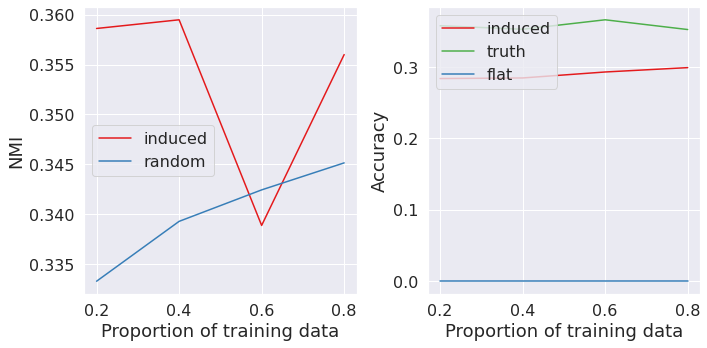

In [90]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

colors = sns.color_palette("Set1", n_colors=3)

mean_accs = np.mean(accs, axis=-1)
mean_evals = np.mean(evals, axis=-1)

ax[0].plot(n_props, mean_evals[:,0], label='induced', c=colors[0])
ax[0].plot(n_props, mean_evals[:,1], label='random', c=colors[1])

ax[0].legend(loc='center left', fontsize=16)

ax[0].set_xticks(n_props)
# ax[1].set_yticks([0.32, 0.34, 0.36, 0.38])
# ax[1].set_ylim(0.31, 0.381)
# ax[1].set_ylabel('Accuracy')
ax[0].set_xlabel('Proportion of training data', fontsize=18)
ax[0].set_ylabel('NMI', fontsize=18)
ax[0].tick_params(labelsize=16)
# ax[0].set_yticks([0.12, 0.16, 0.20, 0.24])

algs = ['truth', 'induced', 'flat']

colors = sns.color_palette('Set1', n_colors=3)

ax[1].plot(n_props, mean_accs[:,1], label='induced', c=colors[0])
ax[1].plot(n_props, mean_accs[:,0], label='truth', c=colors[2])

ax[1].plot(n_props, mean_accs[:,2], label='flat', c=colors[1])
ax[1].legend(loc='upper left', fontsize=16)

ax[1].set_xticks(n_props)
# ax[1].set_yticks([0.32, 0.34, 0.36, 0.38])
# ax[1].set_ylim(0.31, 0.381)
ax[1].set_ylabel('Accuracy', fontsize=18)
ax[1].set_xlabel('Proportion of training data', fontsize=18)
ax[1].tick_params(labelsize=16)

plt.tight_layout()